In [1]:
import os
os.chdir("../../")
import pandas as pd

import spacy
from nltk.corpus import stopwords
from src.text.epu import *
from src.text.utils import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from imblearn.over_sampling import SMOTE
import tiktoken

In [3]:
folder = os.getcwd() + "/data/text/abc_au/"
file_lists = [folder + file for file in os.listdir(folder) if "news" in file]

In [4]:
news_df = pd.DataFrame()
for file in file_lists:
    df = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    if news_df.empty:
        news_df = df
    else:
        news_df = pd.concat([news_df, df], axis=0).reset_index(drop=True)

In [5]:
econ_list = [
    'economy', 'economic', 'economics', 'business', 'commerce', 'finance',
    'industry', "assistance", "science and technology", "trade", "mining and metals industry"
]

In [6]:
tags = {}
for i in news_df["tags"]:
    i = str(i)
    for j in i.split(",")[:-1]:
        j = j.strip().lower()
        if j not in tags:
            
            tags[j] = 1
        else:
            tags[j] +=1

In [7]:
news_df["econ"] = news_df["tags"].str.lower().apply(is_in_word_list, terms=econ_list)

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_stopwords = list(nlp.Defaults.stop_words)

nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [9]:
news_df = news_df.dropna().reset_index(drop=True)

In [10]:
from src.text.utils import *
data = news_df.news.values.tolist()
data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=20, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [11]:
news_df["texts"] = texts_preprocessed
news_df["texts"] = news_df["texts"].apply(lambda x: " ".join(i for i in x))

In [21]:
text_embeddings = [nlp(text).vector for text in news_df["texts"]]  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    news_df['texts'],   
    news_df['econ'].astype(int), 
    test_size=0.1, 
    random_state=42,  
    shuffle=True)   

In [12]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN

X_res, y_res = SMOTETomek().fit_resample(X_train_vectors_tfidf, y_train)

In [13]:
lr_tfidf = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:, 1]


print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1164
           1       0.81      0.58      0.68       208

    accuracy                           0.92      1372
   macro avg       0.87      0.78      0.81      1372
weighted avg       0.91      0.92      0.91      1372

Confusion Matrix: [[1135   29]
 [  87  121]]
AUC: 0.935744614062913


In [14]:
from sklearn.svm import SVC
svc = SVC(C=10,probability=True).fit(X_train_vectors_tfidf, y_train)
y_svc_predict = svc.predict(X_test_vectors_tfidf)
print(classification_report(y_test,y_svc_predict))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1164
           1       0.91      0.64      0.75       208

    accuracy                           0.94      1372
   macro avg       0.92      0.81      0.86      1372
weighted avg       0.93      0.94      0.93      1372



In [15]:
models = [
    RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42),
    MultinomialNB(),
    LinearSVC(random_state=42),
    LogisticRegression(solver='liblinear', C=1, penalty='l2', random_state=42),
    XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)
]

scoring = ['accuracy', 'f1_macro', 'recall', 'precision']

for model in models:
    model_name = model.__class__.__name__
    result = cross_validate(model,
                            X_train_vectors_tfidf,
                            y_train,
                            cv=5,
                            scoring=scoring)
    print(
        "%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%"
        % (model_name, result['test_accuracy'].mean() * 100,
           result['test_f1_macro'].mean() * 100,
           result['test_recall'].mean() * 100,
           result['test_precision'].mean() * 100))

/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/skl

RandomForestClassifier: Mean Accuracy = 84.91%; Mean F1-macro = 45.92%; Mean recall-macro = 0.00%; Mean precision-macro = 0.00%
MultinomialNB: Mean Accuracy = 84.95%; Mean F1-macro = 46.30%; Mean recall-macro = 0.38%; Mean precision-macro = 66.67%


/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: Mean Accuracy = 91.62%; Mean F1-macro = 82.07%; Mean recall-macro = 61.78%; Mean precision-macro = 78.27%
LogisticRegression: Mean Accuracy = 89.27%; Mean F1-macro = 73.07%; Mean recall-macro = 38.91%; Mean precision-macro = 79.56%
XGBClassifier: Mean Accuracy = 91.87%; Mean F1-macro = 81.74%; Mean recall-macro = 57.75%; Mean precision-macro = 83.26%


## PNG

In [16]:
png_files = [
    os.getcwd() + "/data/text/png/post_courier_news.csv",
    os.getcwd() + "/data/text/rnz/papua_new_guinea_rnz_news.csv",
    os.getcwd() + "/data/text/abc_au/papua_new_guinea_abc_news.csv",
]

png = pd.DataFrame()
for png_file in png_files:
    temp = pd.read_csv(png_file).drop("Unnamed: 0", axis=1)
    if png.empty:
        png = temp
    else:
        png = pd.concat([png, temp], axis=0).reset_index(drop=True)

In [17]:
png = png[png.news.isna() == False].reset_index(drop=True)

In [18]:
png_data = png.news.values.tolist()
png_data_words = list(sent_to_words(png_data))

bigram = gensim.models.Phrases(png_data_words, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[png_data_words], min_count=20, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

png_texts = preprocess_text(png_data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [19]:
png["date"] = pd.to_datetime(png["date"], format='mixed')
png["texts"] = png_texts
png["texts"] = png["texts"].apply(lambda x: " ".join(i for i in x))

In [20]:
png_tfidf_pred = tfidf_vectorizer.transform(png["texts"])
png_pred = svc.predict(png_tfidf_pred)

In [21]:
png["econ_pred"] = png_pred
png_econ = png[png.econ_pred == 1].reset_index(drop=True)

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in png_econ.news:
    sample = row.replace("\n", " ").strip()
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)

In [24]:
png_econ["sentiment"] = sent_df["compound"].tolist()
png_econ["date"] = [d.date() for d in png_econ["date"]]
png_econ["date"] = [pd.to_datetime(d) for d in png_econ["date"]]
png_econ_sent = png_econ.set_index("date").groupby(pd.Grouper(freq="MS"))[["sentiment"]].mean().reset_index()

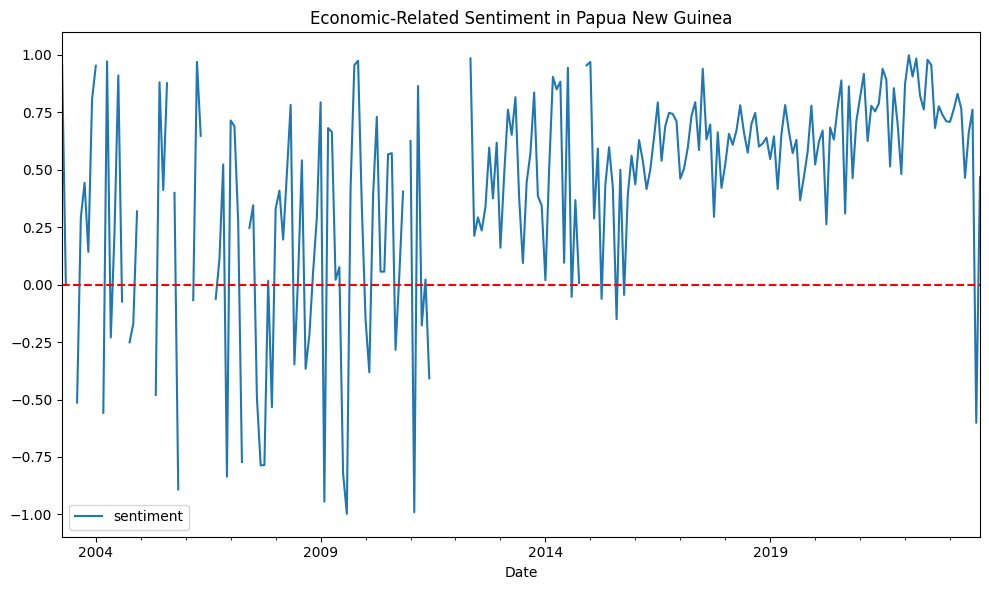

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
png_econ_sent.plot(x="date", ax=ax);
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Date")
plt.title("Economic-Related Sentiment in Papua New Guinea")
plt.tight_layout()
fig.savefig(os.getcwd()+"/outputs/text/png/png_econ_sentiment.png", dpi=400)

## SIB

In [29]:
sib_files = [
    os.getcwd() + "/data/text/rnz/solomon_islands_rnz_news.csv",
    os.getcwd() + "/data/text/abc_au/solomon_islands_abc_news.csv",
]

sib_folder = os.getcwd() + "/data/text/solomon_islands/"
sib_files.extend([sib_folder+file for file in os.listdir(sib_folder) if "news" in file])

In [33]:
sib = pd.DataFrame()
for file in sib_files:
    temp = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    if sib.empty:
        sib = temp
    else:
        sib = pd.concat([sib, temp], axis=0).reset_index(drop=True)

sib = sib[sib.news.isna() != True].reset_index(drop=True)

In [34]:
sib_data = sib.news.values.tolist()
sib_data_words = list(sent_to_words(sib_data))

bigram = gensim.models.Phrases(sib_data_words, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[sib_data_words], min_count=20, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

sib_texts = preprocess_text(sib_data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [35]:
sib["date"] = pd.to_datetime(sib["date"], format='mixed')
sib["texts"] = sib_texts
sib["texts"] = sib["texts"].apply(lambda x: " ".join(i for i in x))

In [36]:
sib_tfidf_pred = tfidf_vectorizer.transform(sib["texts"])
sib_pred = svc.predict(sib_tfidf_pred)

In [37]:
sib["econ_pred"] = sib_pred
sib_econ = sib[sib.econ_pred == 1].reset_index(drop=True)

In [38]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in sib_econ.news:
    sample = row.replace("\n", " ").strip()
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)

In [39]:
sib_econ["sentiment"] = sent_df["compound"].tolist()
sib_econ["date"] = [d.date() for d in sib_econ["date"]]
sib_econ["date"] = [pd.to_datetime(d) for d in sib_econ["date"]]
sib_econ_sent = sib_econ.set_index("date").groupby(pd.Grouper(freq="MS"))[["sentiment"]].mean().reset_index()

In [46]:
sib_econ_sent[sib_econ_sent.date >= "2011-01-01"].head(20)

,date,sentiment
91,2011-01-01,0.878500
92,2011-02-01,0.933483
93,2011-03-01,0.953929
94,2011-04-01,0.849688
95,2011-05-01,0.893327
96,2011-06-01,0.761678
97,2011-07-01,0.742758
98,2011-08-01,0.960333
99,2011-09-01,0.816700
100,2011-10-01,0.817550


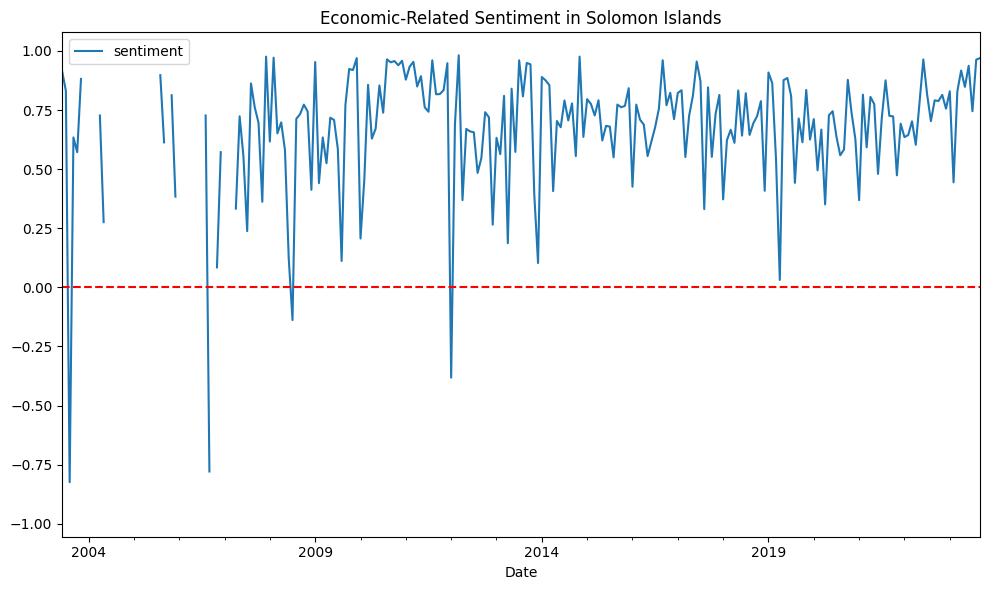

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
sib_econ_sent.plot(x="date", ax=ax);
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Date")
plt.title("Economic-Related Sentiment in Solomon Islands")
plt.tight_layout()
fig.savefig(os.getcwd()+"/outputs/text/solomon_islands/sib_econ_sentiment.png", dpi=400)